# Hierarchical Window Clustering Approach to detecting Spiking Motifs 

### This notebook is a continuation of "HDP detecting spiking motifs (Part 1)"

This notebook extends the clustering method of the previous notebook. Including the following:
1. Creates windows around each pattern that was found aiming to improve the SNR of found patterns
1. Reducing redundant or overlapping patterns.
2. Performance is measured by the span of the correlation matrix of detected patterns and ground truth patterns.

## Data Generation

In [34]:
'''
Model parameters
'''
import random
import numpy as np


M = 4 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 40 # hz
pg_fr = 4 # hz
background_noise_fr = 50 # h

np.random.seed(0)

In [35]:
params = {'M': 4, 'N': 60, 'D': 30, 'T': 1000, 'nrn_fr': 10, 'pg_fr': 4, 'background_noise_fr': 1}
M,N,D,T,nrn_fr,pg_fr,background_noise_fr = params.values()

In [36]:
'''
Setup
'''

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys
np.set_printoptions(threshold=sys.maxsize)
disp_figs = True
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 101 colors (11 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])

In [37]:
'''
Synthetic Data Generation
'''
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)


'''
Synthetic Data Generation
'''
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.rand(N,D,M)*1000
nrn_frs = np.zeros((M))
for m in range(M):
    nrn_frs[m] = np.random.poisson(nrn_fr)
    K_dense[:,:,m] = (K_dense[:,:,m] < nrn_frs[m]).astype('int')
K_sparse = np.where(K_dense)
K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)


# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.rand(M,T)*1000
pg_frs = np.zeros((M))
for m in range(M):
    pg_frs[m] = np.random.poisson(pg_fr)
    B_dense[m,:] = (B_dense[m,:] < pg_frs[m]).astype('int')
B_sparse = np.where(B_dense)
B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,0] = np.random.rand(N,T+D)*1000
A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b-1]

A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1

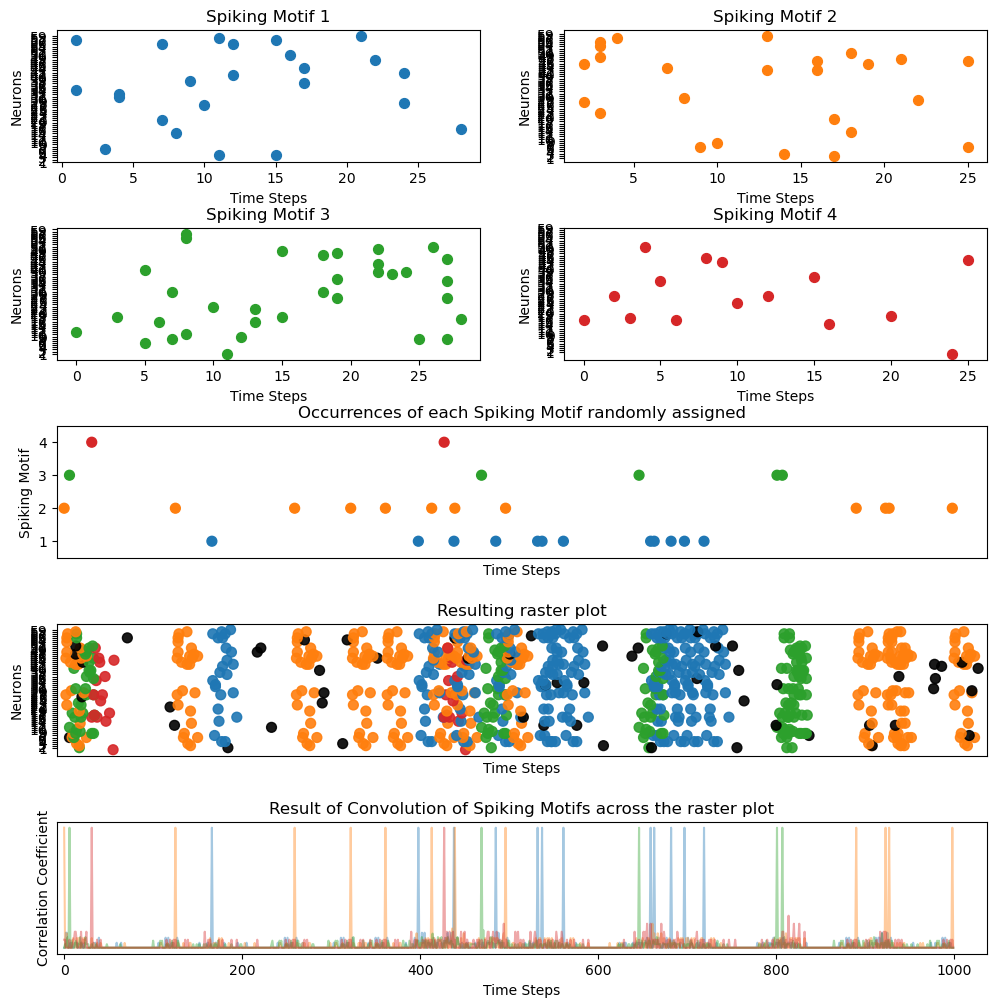

In [38]:
import matplotlib.ticker as ticker

fig, ax = plt.subplot_mosaic('AB;CD;EE;FF;GG', figsize=(12, 12), gridspec_kw={'height_ratios': [1, 1, 1, 1, 1]})

s = 50

# Scatter plots for A, B, C, D
for i, k in enumerate(['A', 'B', 'C', 'D']):
    ax[k].scatter(K_sparse[1][K_sparse[2] == i+1], K_sparse[0][K_sparse[2] == i+1], c=palette[i+1], s=s)
    ax[k].set_title(f'Spiking Motif {i + 1}')  # Updated title for plots A, B, C, D
    ax[k].set_xlabel('Time Steps')
    ax[k].set_ylabel('Neurons')
    ax[k].set_yticks(range(1, N))

spiking_motif_data = [B_sparse[0][B_sparse[1] == i+1] for i in range(4)]  # Collect data for each Spiking Motif
ax['E'].scatter(B_sparse[1], B_sparse[0]-1, c=palette[B_sparse[0]], s=s)
ax['E'].set_title('Occurrences of each Spiking Motif randomly assigned')
ax['E'].set_xlabel('Time Steps')
ax['E'].set_ylabel('Spiking Motif')  # Updated y-axis label for plot E

# Set y-axis ticks and labels explicitly for Spiking Motifs 1 to 4
ax['E'].set_yticks(range(0, M))  # Set y-axis ticks for plot E to represent the four Spiking Motifs
ax['E'].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x) + 1}'))  # Map y-axis labels to display 1 through 4
ax['E'].set_ylim(-0.5, 3.5)  # Set y-axis limits to display only the ticks and labels for the existing values


# Scatter plot for F
ax['F'].scatter(A_sparse[1], A_sparse[0], c=palette[A_sparse[2]], alpha=0.9, s=s*4, marker='.')
ax['F'].set_title('Resulting raster plot')
ax['F'].set_xlabel('Time Steps')
ax['F'].set_ylabel('Neurons')  # Y-axis represents neurons, no need to update y-axis label
ax['F'].set_yticks(range(1, N))  # Set y-axis ticks for plot F to represent neurons

sanity_check = np.zeros((T,M))
for j in range(M):
    for i in range(T):
        sanity_check[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    sanity_check[:,j] = sanity_check[:,j]/np.max(sanity_check[:,j])

# Plot for G
[ax['G'].plot(sanity_check[:, i], color=palette[i+1], alpha=0.4) for i in range(M)]
ax['G'].set_title('Result of Convolution of Spiking Motifs across the raster plot')
ax['G'].set_xlabel('Time Steps')
ax['G'].set_ylabel('Correlation Coefficient')  # Updated y-axis label for plot G
ax['G'].set_yticks([])  # Remove y-axis ticks for plot G

# Set common x-axis from 0 to 1000 with padding
common_xlim = (min(A_sparse[1]), max(A_sparse[1]))
padding = 10
ax['E'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
ax['F'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)
ax['G'].set_xlim(common_xlim[0] - padding, common_xlim[1] + padding)

# Share x-axis for E, F, and G
ax['E'].sharex(ax['F'])
ax['G'].sharex(ax['F'])

# Hide x-axis ticks and labels for E and F
ax['E'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax['F'].tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

plt.show()


In [43]:
sum([A_sparse[0].tolist().count(n) for n in np.unique(A_sparse[0])])

843

This is the generated dataset that we will be working with. The lower panel shows the convolution of the the "Spiking Motifs" with the full raster plot. This convolution shows that by knowing the shape of the spiking motifs, the patterns can be robustly detected.

## Clustering 1

In [40]:
'''
Post-processing and clustering
'''

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Windowing the data
window_dim = (int(np.ceil(D/2)), N) # choosing a window to surround the spikes, this is a prediction but for now we will use the a priori depth D
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0]) # spikes closer to border will not be counted for simplicity
A_trunc = (A_sparse[0][valid_spikes],A_sparse[1][valid_spikes].copy(),A_sparse[2][valid_spikes].copy()) # creating a new "A_sparse" with only valid spikes
M_labels = A_sparse[2][valid_spikes]
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2)) # creating a matrix of all of the windows surrounding every spike in the matrix
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
    
HDPs = []
sim_mats = []
# Set the cutoff value for clustering
cutoff = 1

# Get the cluster assignments for each spike based on the hierarchical clustering
clusters = []
for n in range(N):
    windows_n = windows[N_labels==n]
    if len(windows_n) > 1:
        x = np.zeros((len(windows_n),len(windows_n)))
        for i in range(windows_n.shape[0]):
            for j in range(windows_n.shape[0]):
                x[i,j] = np.sum(windows_n[i]*windows_n[j])/ min(np.sum(windows_n[i]),np.sum(windows_n[j]))
        sim_mats.append(x)
        dissimilarity = 1 - x
        if not np.all(dissimilarity == 0):
            HDPs.append(linkage(dissimilarity, method='complete'))
            clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))
    elif len(windows_n) == 1:
        clusters += [n*100]


clusters= np.array(clusters)

C:\Users\miles\AppData\Local\Temp\ipykernel_5816\2813406777.py:36: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  HDPs.append(linkage(dissimilarity, method='complete'))
C:\Users\miles\AppData\Local\Temp\ipykernel_5816\2813406777.py:37: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))


In [41]:
len(valid_spikes)

843

## Clustering 2

In [42]:
time_differences = []
cluster_sq = {}
for cluster in np.unique(clusters):
    time_differences.append(list(np.diff(A_trunc[1][clusters == cluster])))
    if str(list(np.diff(A_trunc[1][clusters == cluster]))) in cluster_sq.keys():
        cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] + [cluster]
    else: 
        cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = [cluster]
        
''' 
This is the second round of clustering. Only patterns that repeat across multiple neurons are considered a motif. 


with some help from chatgpt
'''

from collections import Counter

# Convert the list of lists to a set of tuples to remove duplicates
unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

# Convert the set of tuples back to a list of lists
unique_sublists = [list(sublist) for sublist in unique_sublists_set]

# Count the occurrences of each unique sublist in the original list
sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)
sublist_counts[(0,)] = 0

# Print the unique sublists and their respective counts
for sublist in unique_sublists:
    count = sublist_counts[tuple(sublist)]
    print(f"{sublist}: {count} occurrences")

sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron

''' to visualize the clusters'''

recovered_labels = np.zeros_like(clusters)
for l, key in enumerate(sublist_keys_filt):
    for k in cluster_sq[str(key)]:
        recovered_labels[clusters == k] = l+1

''' to get the timings'''

# Sort y according to x
sorted_indices = np.argsort(A_trunc[1])
sorted_x = A_trunc[1][sorted_indices]

all_times = []
all_labels = []
for key in sublist_keys_filt:
    pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
    for i,k in enumerate(cluster_sq[str(key)]):
        pattern_repetition_labels[i][clusters==k] = 1
        pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
    pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
    all_labels.append(pattern_repetition_labels)
    
    sorted_y = pattern_repetition_labels[sorted_indices]
    pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
    all_times.append(pattern_times)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 786 but corresponding boolean dimension is 784

### Window the labeled times to improve the pattern shape

When the density of spikes is high, the extracted patterns are garbage.
Let's look at the patterns that were detected...

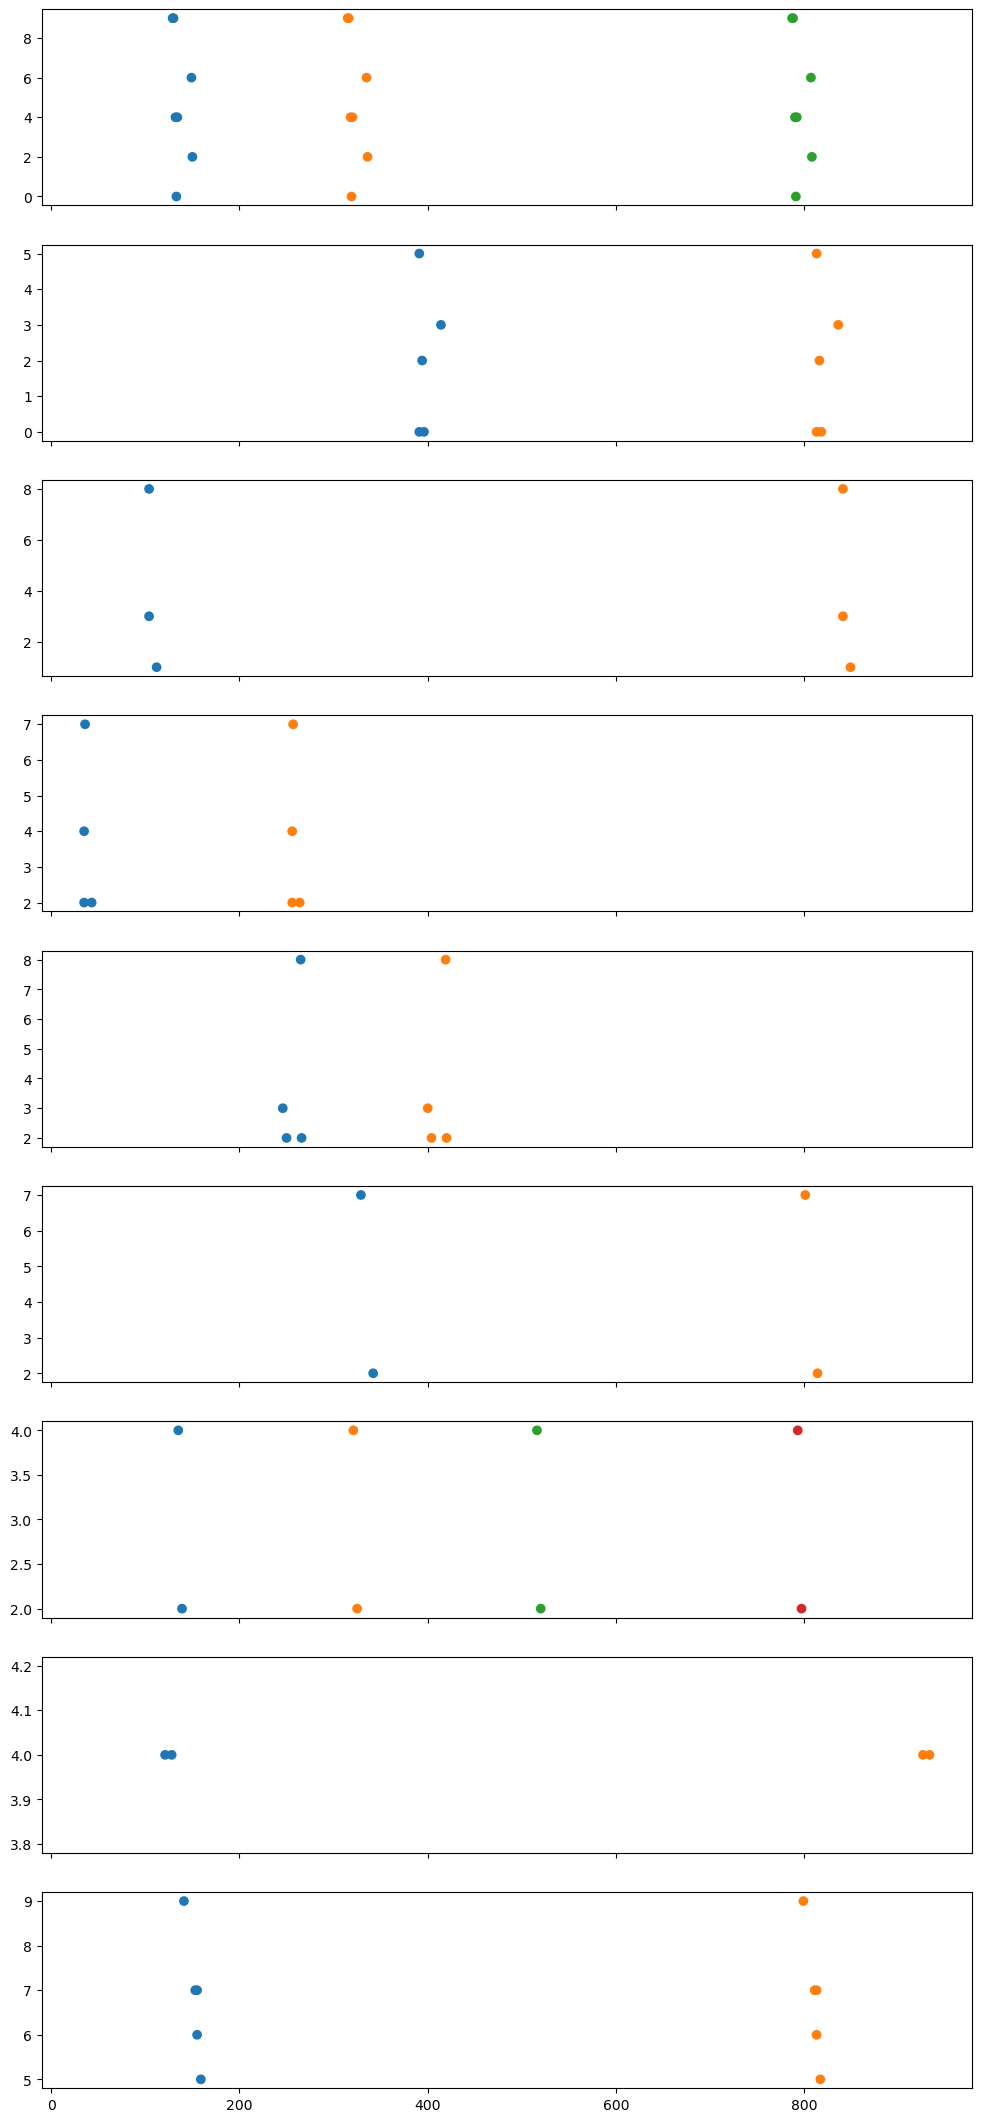

In [63]:
# Create the figure and subplots
fig, ax = plt.subplots(len(all_labels), 1, figsize=(12, 3*len(all_labels)), sharex=True)
for i in range(len(all_labels)):
    ax[i].scatter(A_trunc[1][all_labels[i]!=0],A_trunc[0][all_labels[i]!=0],c=palette[all_labels[i][all_labels[i]!=0]])
plt.show()

The algorithm was able to find repeating patterns, but was not able to combine these patterns into the ground truth patterns.
To recombine combinations of patterns, I take a window at each repetition of the pattern in the raster plot and sum them up. I then take the mask where there is 100% overlap in pixels. 

In [10]:
n = N
d = D
m = len(all_labels)
new_windows = []
all_times_ = []
pattern_num = []
pattern_template = []
for i in range(len(all_times)):
    template = np.zeros((n,d*2))
    pattern_template.append(template.copy())
    for time in all_times[i]:
        p = A_dense[:,max(time-d,0):min(time+d,A_dense.shape[1])]
        d_ = d*2 - p.shape[1]
        template[:,d_:] = p
        new_windows.append(template)
        pattern_template[-1] += template
        template = np.zeros((n,d*2))
        
    

Lets visualize the overlapping instnaces of the pattern

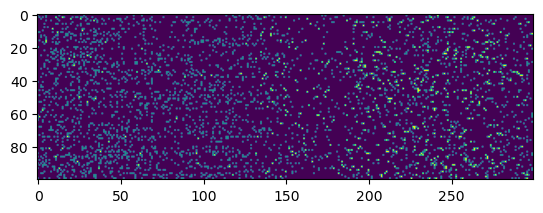

In [11]:
plt.figure()
plt.imshow(pattern_template[0])

In [12]:
for i,p in enumerate(pattern_template):
    p[p != np.max(p)] = 0
    p[p == np.max(p)] = 1
    offset = np.min(np.where(p)[1])
    pattern_template[i] = np.concatenate((p[:,offset:], p[:,:offset]),axis=1)
pattern_template = np.array(pattern_template)


In [13]:
pattern_template.shape

(11, 100, 300)

In [14]:
all_times

[array([377, 614], dtype=int64),
 array([160, 524], dtype=int64),
 array([264, 842], dtype=int64),
 array([210, 604], dtype=int64),
 array([387, 793], dtype=int64),
 array([286, 531], dtype=int64),
 array([277, 522, 855], dtype=int64),
 array([105, 601], dtype=int64),
 array([456, 911], dtype=int64),
 array([303, 534], dtype=int64),
 array([298, 525], dtype=int64)]

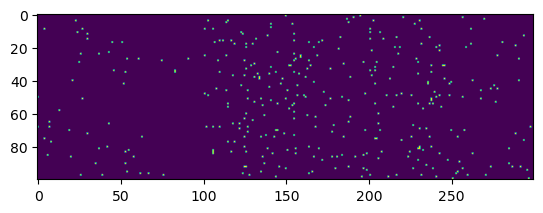

In [15]:
plt.figure()
plt.imshow(pattern_template[3])

Filtering to take the mask at overlapping pixel == 100%

plt.figure()
plt.imshow(pattern_template[0])

We are left with pattern template candidates. There could be several copies of the same pattern template. 
There could be overlapping pattern templates that very by n pixels. There could even be more patterns than initialized if
a noisy spike occurs at just the right time.
One approach (and the one that so far results in the best performance) is to correlate each pattern and re-cluster the templates.




In [16]:
from scipy.signal import correlate

matrix_x = pattern_template
matrix_y = pattern_template

# Calculate cross-correlation matrix
cross_corr_matrix = np.zeros((matrix_x.shape[0], matrix_y.shape[0]))

for x_channel_idx in range(matrix_x.shape[0]):
    for y_channel_idx in range(matrix_x.shape[0]):
        cross_corr = correlate(matrix_x[x_channel_idx,...], matrix_x[y_channel_idx,...], mode='full')
        max_corr = np.max(cross_corr)/ np.sum(matrix_x[x_channel_idx])
        cross_corr_matrix[x_channel_idx, y_channel_idx] = max_corr

dissimilarity = cross_corr_matrix-1

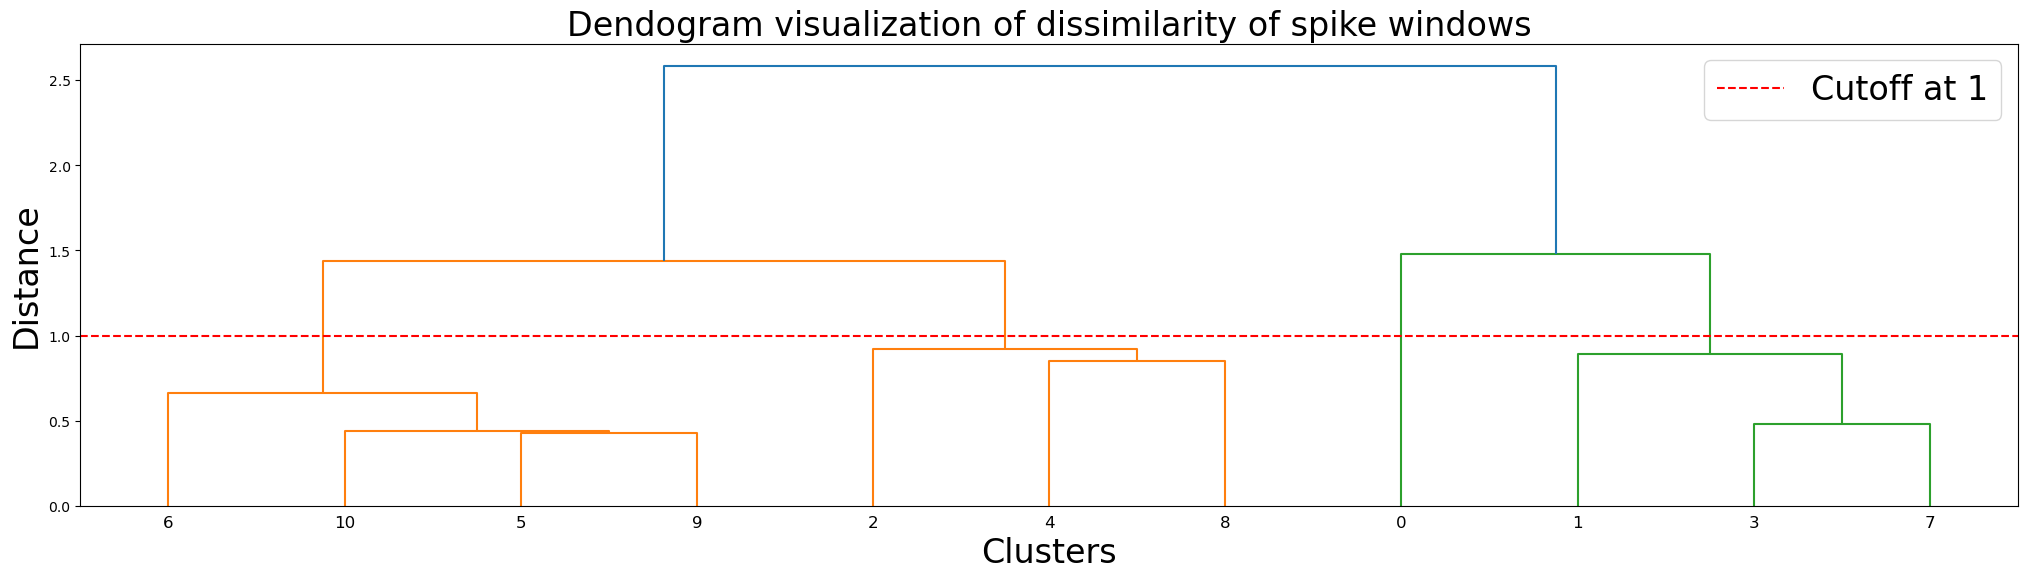

In [17]:
# Create the dendrogram plot
fig = plt.figure(figsize=(25, 6))
HDP = linkage(dissimilarity, method='complete')
dn = dendrogram(HDP)

# Add a horizontal line at the cutoff value of 1
plt.axhline(y=1, color='r', linestyle='--', label='Cutoff at 1')

# Add labels and legend
plt.title("Dendogram visualization of dissimilarity of spike windows", fontsize=24)
plt.ylabel('Distance', fontsize=24)
plt.xlabel('Clusters', fontsize=24)
plt.legend(fontsize=24)

plt.show()

In [18]:
method1_labels = fcluster(HDP,cutoff, criterion='distance')

pattern_convolutions = np.zeros((pattern_template.shape[0], A_dense.shape[1]+pattern_template.shape[2]-1))
for j in range(pattern_template.shape[0]):
    for i in range(pattern_template.shape[1]):
        pattern_convolutions[j] += correlate(A_dense[i,:], pattern_template[j,i,:], mode='full')
    pattern_convolutions[j] /= np.sum(pattern_template[j,:,:]) # normalize the convolution
    
detected_patterns = pattern_convolutions.copy()
detected_patterns[detected_patterns != 1] = 0
detected_patterns = np.sum(detected_patterns,axis=1)

method1_pattern_winners = []
for l in np.unique(method1_labels):
    idc = np.where(method1_labels==l)[0]
    temp = detected_patterns[method1_labels==l]
    method1_pattern_winners.append(idc[temp == max(temp)][0])
    
method1_pattern_template = pattern_template[method1_pattern_winners]
method1_pattern_template.shape

print('Method 1 detected patterns:', method1_pattern_winners)

Method 1 detected patterns: [6, 2, 1, 0]


Once the patterns are clustered, a pattern "winner" from each cluster is chosen based on how many patterns it detects. Pattern templates that detect more patterns are assumed to be "better" than it's competitors within the same clsuter labe. 
method1_pattern_winners shows the indices of the patterns winners that emerge.

## Performance - Comparing Detected STM's

In [19]:
def get_acc(matrix_x,matrix_y):
    from scipy.signal import correlate
    # Calculate cross-correlation matrix
    cross_corr_matrix = np.zeros((matrix_x.shape[2], matrix_y.shape[2]))

    for x_channel_idx in range(matrix_x.shape[2]):
        for y_channel_idx in range(matrix_y.shape[2]):
            cross_corr = np.zeros((matrix_x.shape[1]+matrix_y.shape[1]-1))
            for n in range(matrix_x.shape[0]):
                cross_corr += correlate(matrix_x[n, :, x_channel_idx], matrix_y[n, :, y_channel_idx], mode='full')
            max_corr = np.max(cross_corr) / max(np.sum(matrix_x[...,x_channel_idx]),np.sum(matrix_y[...,y_channel_idx]))
            cross_corr_matrix[x_channel_idx, y_channel_idx] = max_corr
#     print(cross_corr_matrix)
#     print( np.sum(matrix_x[...,x_channel_idx]))
    SM_acc_m1 = np.max(cross_corr_matrix,axis=1)
    return SM_acc_m1, cross_corr_matrix

In [20]:
matrix_x = K_dense
matrix_y = method1_pattern_template
matrix_y = np.transpose(matrix_y,[1,2,0])

SM_acc_m1, cc_1 = get_acc(matrix_x,matrix_y)

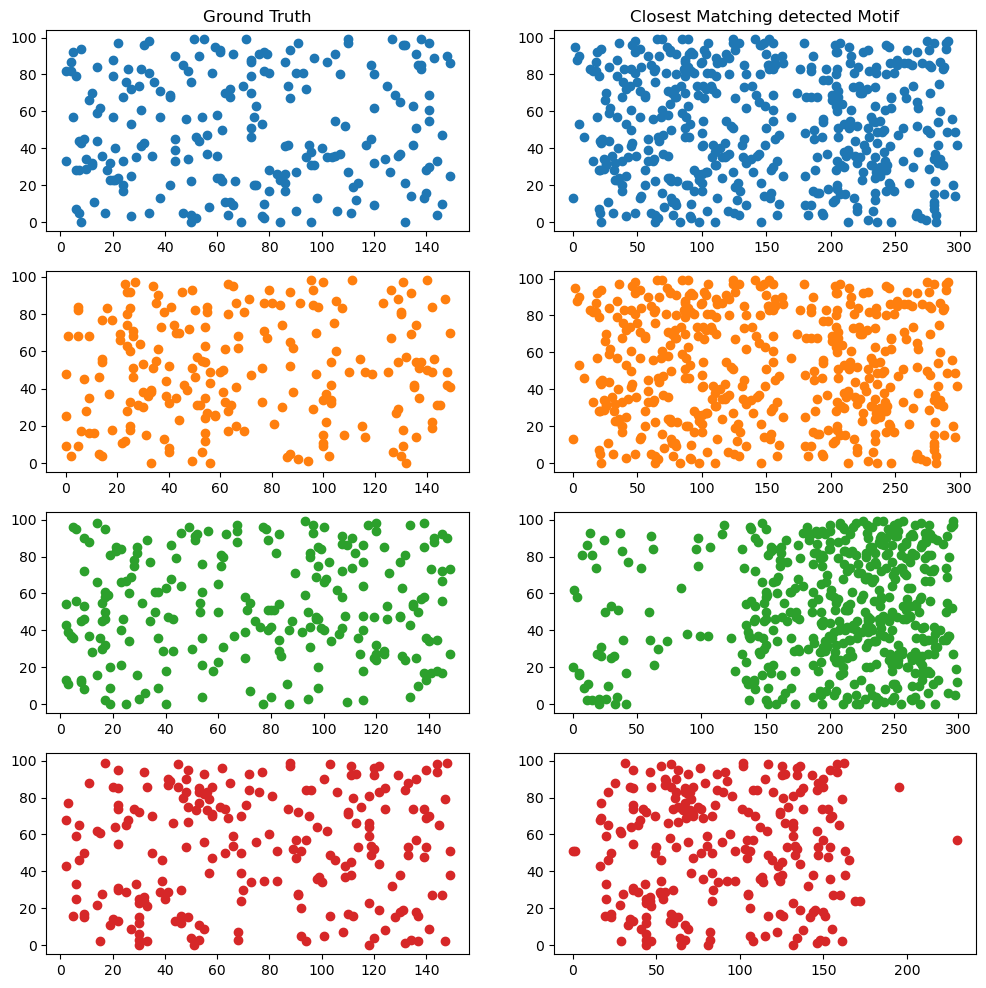

In [21]:
motif_map = (np.arange(0,M),np.argmax(cc_1,axis=1))
motif_map
fig,ax = plt.subplots(len(motif_map[0]),len(motif_map),figsize=(12,M*3))
for i,(a,b) in enumerate(zip(motif_map[0],motif_map[1])):
    ax[i,0].scatter(np.where(K_dense[...,a])[1],np.where(K_dense[...,a])[0],c=palette[i+1])
    ax[i,1].scatter(np.where(method1_pattern_template[b])[1],np.where(method1_pattern_template[b])[0],c=palette[i+1])

ax[0,0].set_title('Ground Truth')
ax[0,1].set_title('Closest Matching detected Motif')
plt.show()

In [22]:
print('Method 1, average SM_accuracy: ', sum(SM_acc_m1)/M)
print('Method 1, SM_accuracy: ', SM_acc_m1)

Method 1, average SM_accuracy:  0.5521294146401076
Method 1, SM_accuracy:  [0.4625     0.37083333 0.46906188 0.90612245]
